In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

2021-09-12 21:44:49.862635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-12 21:44:49.862664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')


In [ ]:
data.head()

In [ ]:
test.head() # Note that it does not have "SalePrice" column

In [3]:
data, test = data.select_dtypes(include=np.number), test.select_dtypes(include=np.number) # Take only numeric columns
data, test = data.dropna(), test.dropna() # Drop rows with null values


In [4]:
data.pop('Id') # Pop id column
test_ids = test.pop('Id')

data_y = data.pop('SalePrice')

data = (data - data.mean()) / data.std()
test = (test - test.mean()) / test.std()


array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

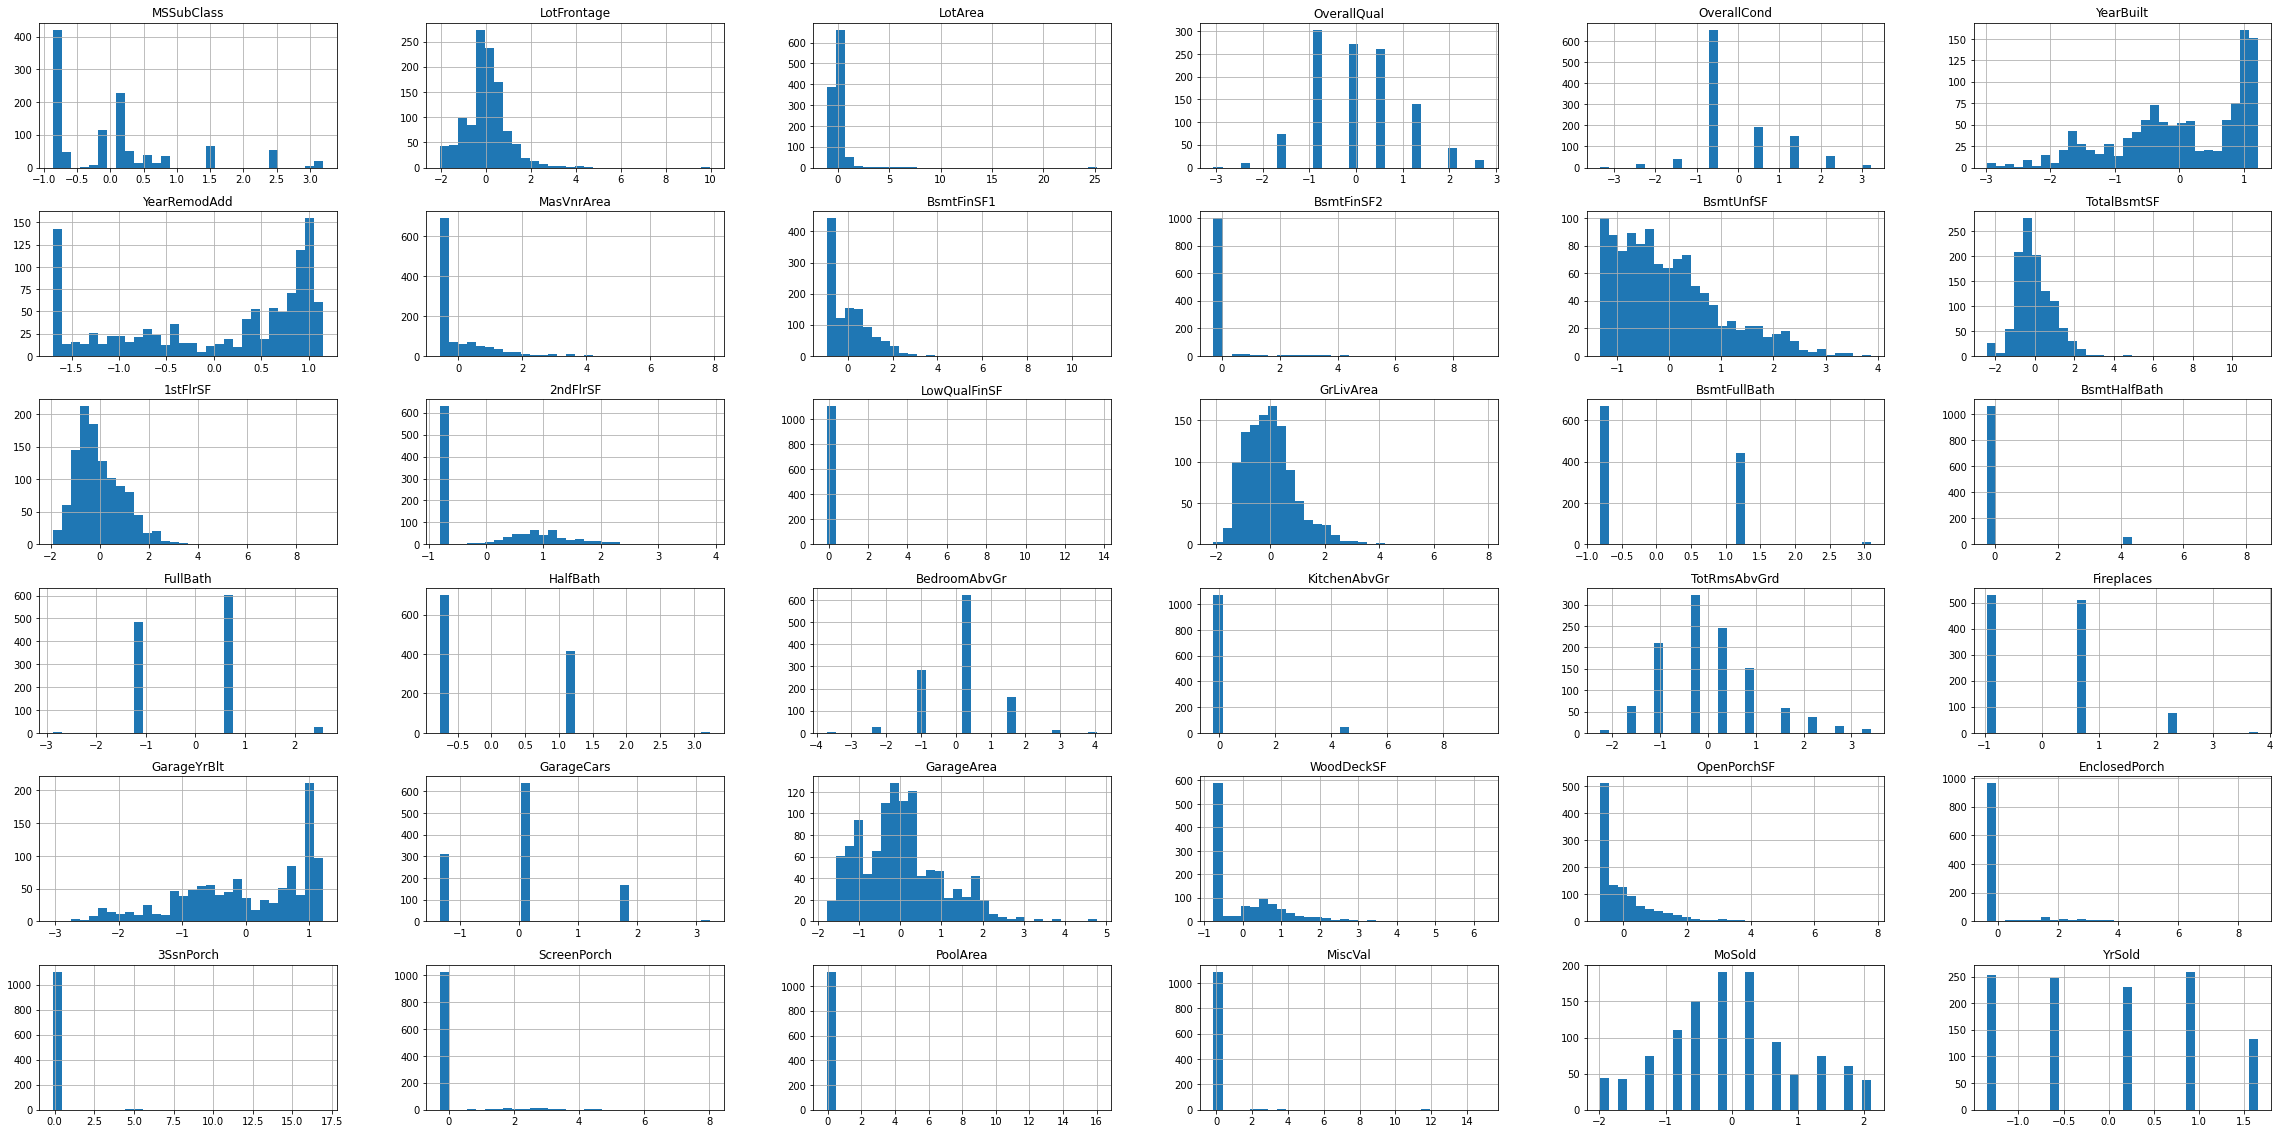

In [23]:
data.hist(figsize=(40,20), bins=30)

<AxesSubplot:>

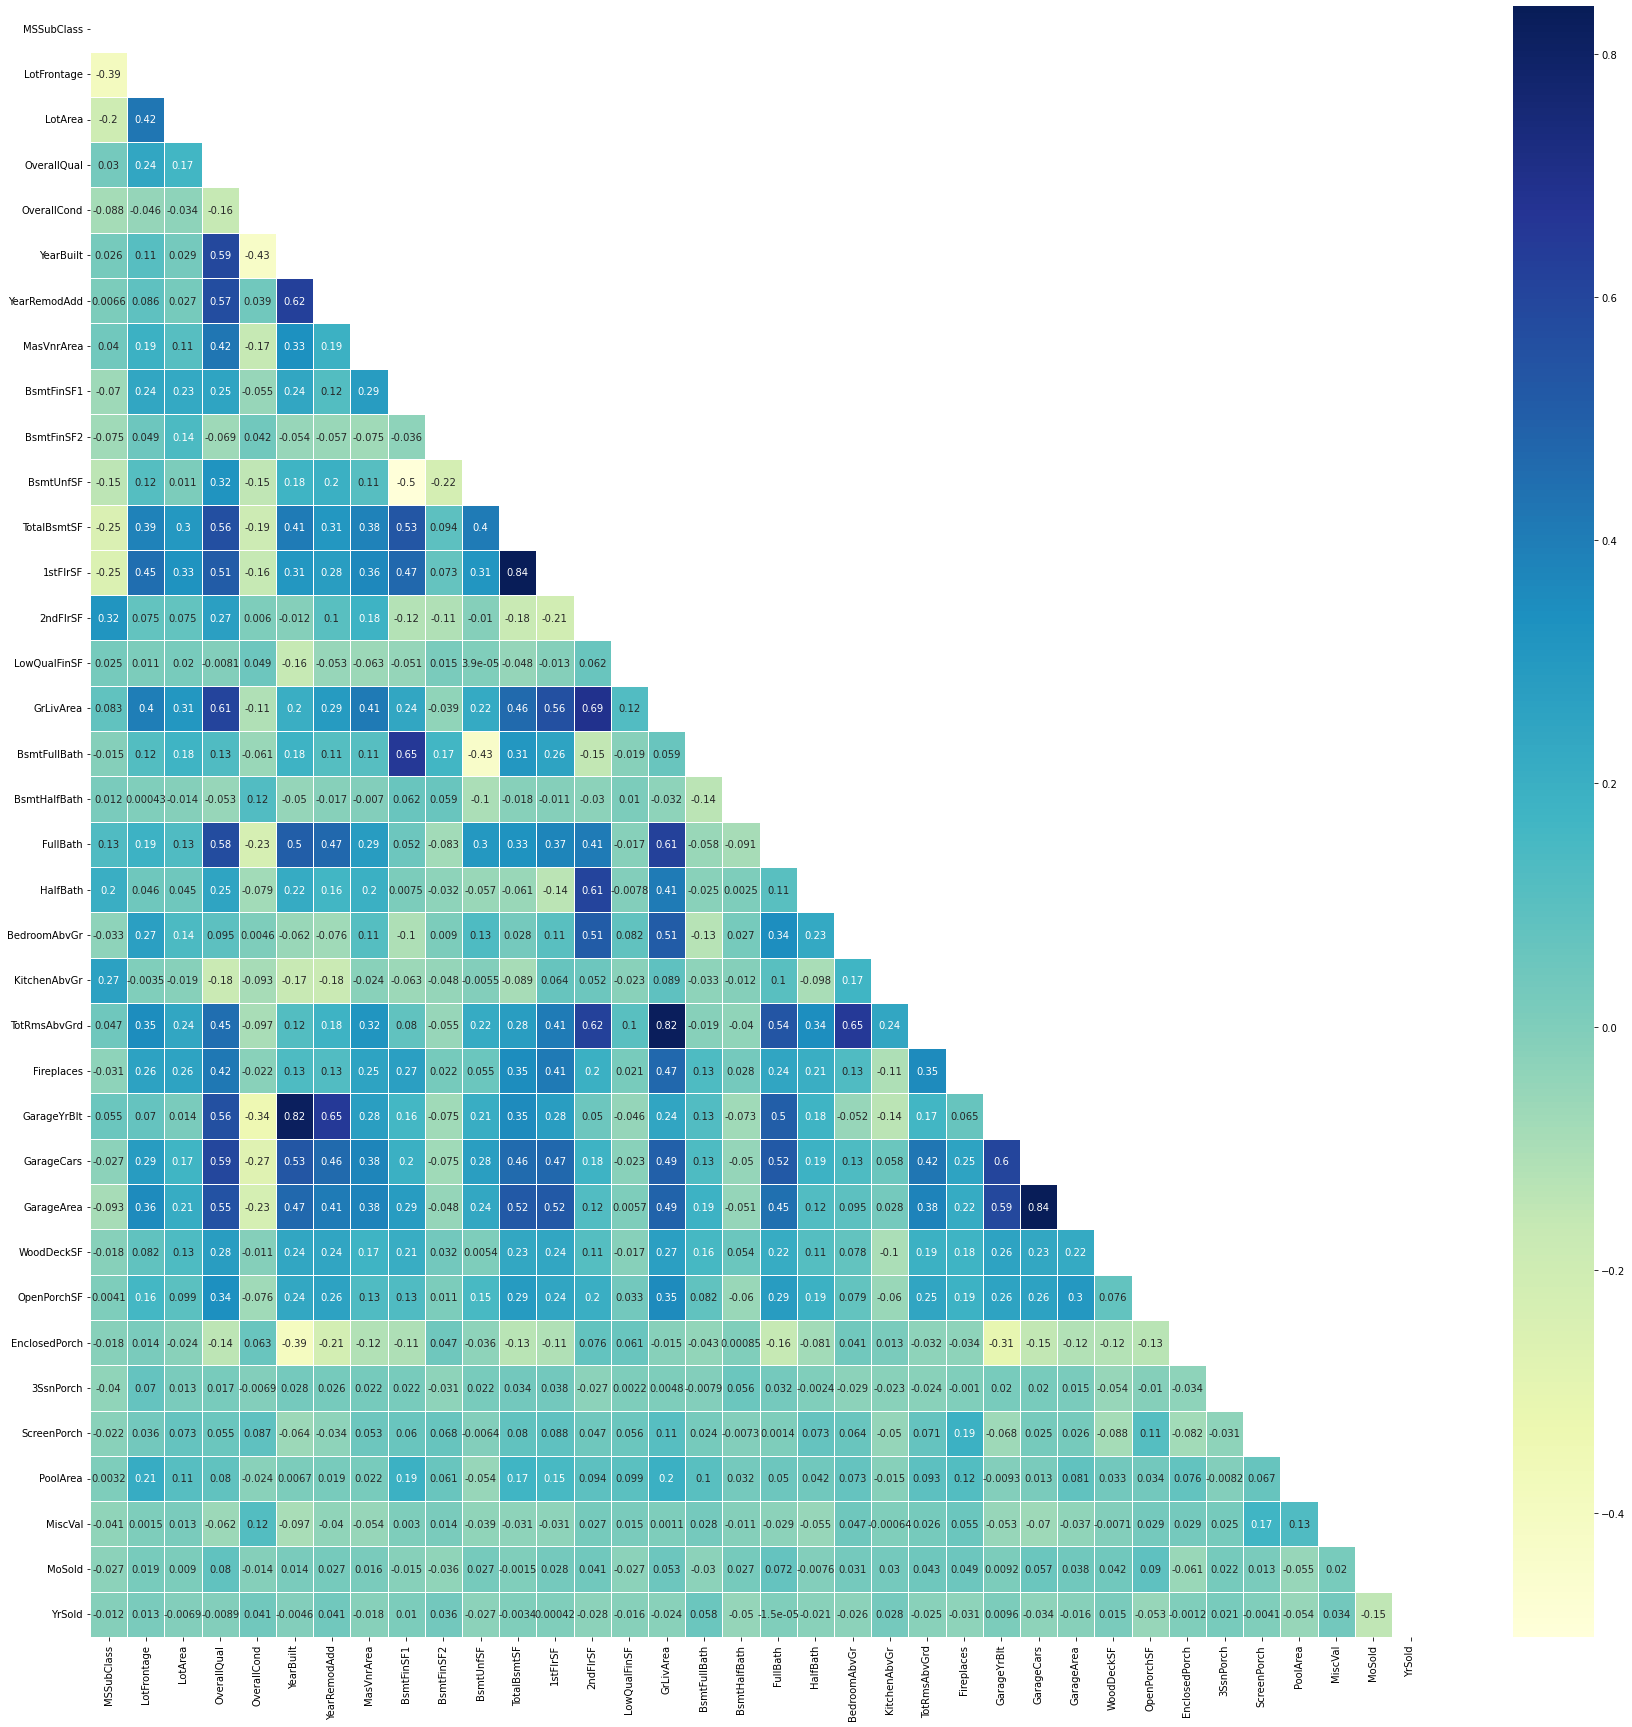

In [24]:
plt.figure(figsize=(30, 30))
sns.heatmap(data.corr(), annot=True, linewidth=.8, mask=np.triu(data.corr()), cmap="YlGnBu")

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, data_y, test_size=0.2, random_state=0)
x_train, x_test, y_train, y_test, test = x_train.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy(), test.to_numpy()
x_train.shape, x_test.shape, y_train.shape, y_test.shape, test.shape

((896, 36), (225, 36), (896,), (225,), (1146, 36))

In [34]:
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.05)
xgb.fit(x_train, y_train)

SVR_ = SVR()
SVR_.fit(x_train, y_train)

model = Sequential()
model.add(Input(shape=[len(x_train[0])]))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(1))

model.compile(loss='log_cosh', optimizer=Adam(), metrics=['mae', 'mse'])
model.fit(x_train, y_train, epochs=60, batch_size=10, verbose=0)


In [35]:
svr_pred = SVR_.predict(x_test)
xbg_pred = xgb.predict(x_test)
nn_pred = model.predict(x_test)

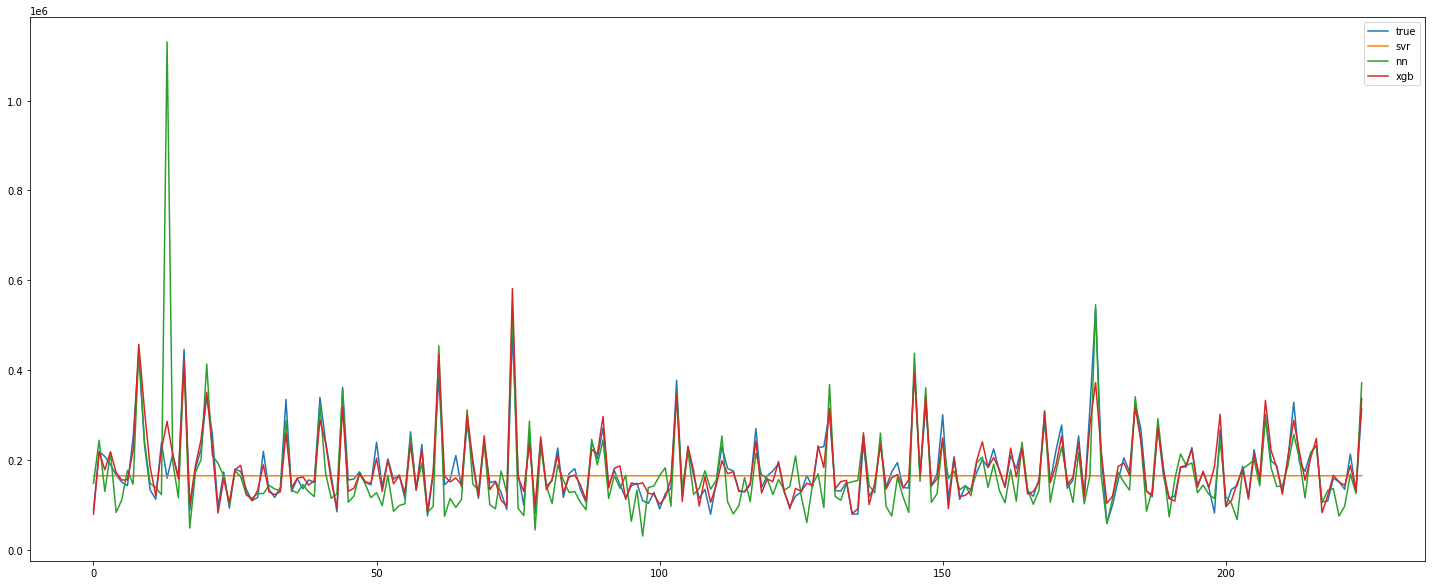

In [36]:
plt.figure(figsize=(25,10))
plt.plot(y_test, label='true')
plt.plot(svr_pred, label='svr')
plt.plot(nn_pred, label='nn')
plt.plot(xbg_pred, label='xgb')
plt.legend()

In [33]:
print(mean_absolute_error(y_test, svr_pred), mean_absolute_error(y_test, xbg_pred), mean_absolute_error(y_test, nn_pred))
print(mean_squared_error(y_test, svr_pred), mean_squared_error(y_test, xbg_pred), mean_squared_error(y_test, nn_pred))
# Normalized
# 0.9282734667765483 0.8660365867802587 0.8923952496738474
# 1.190166986678966 1.0895047301607768 1.1365680271042995

# Not normalized
# 53934.39040398927 16078.581527777778 29993.961284722223
# 6015975116.898481 649771172.155702 4157502508.771032

53904.09341861096 16072.031631944445 41743.68584201389
6013018850.46197 649419654.7721092 6338334689.077598


In [10]:
preds = xgb.predict(test)


In [11]:

with open('submission.txt', 'w') as file:
    for row in list(zip(test_ids, preds)):
        file.write(f'{row[0]}, {row[1]:.2f}\n')
